In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Epydemix import
import sys
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel
from epydemix.plotting import plot_quantiles, plot_spectral_radius
from epydemix.utils import compute_days

population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

# Defining Parameters

Using ```add_parameter``` for each parameter:

In [2]:
# create model 
model = EpiModel(compartments=["S", "R"])

# compartments can be also added after the first init call
model.add_compartments("I")

# define parameters
model.add_parameter(name="beta", value=0.04)
model.add_parameter(name="mu", value=0.2)

# add transitions 
model.add_transition(source="S", target="I", rate="beta", agent="I")
model.add_transition(source="I", target="R", rate="mu")

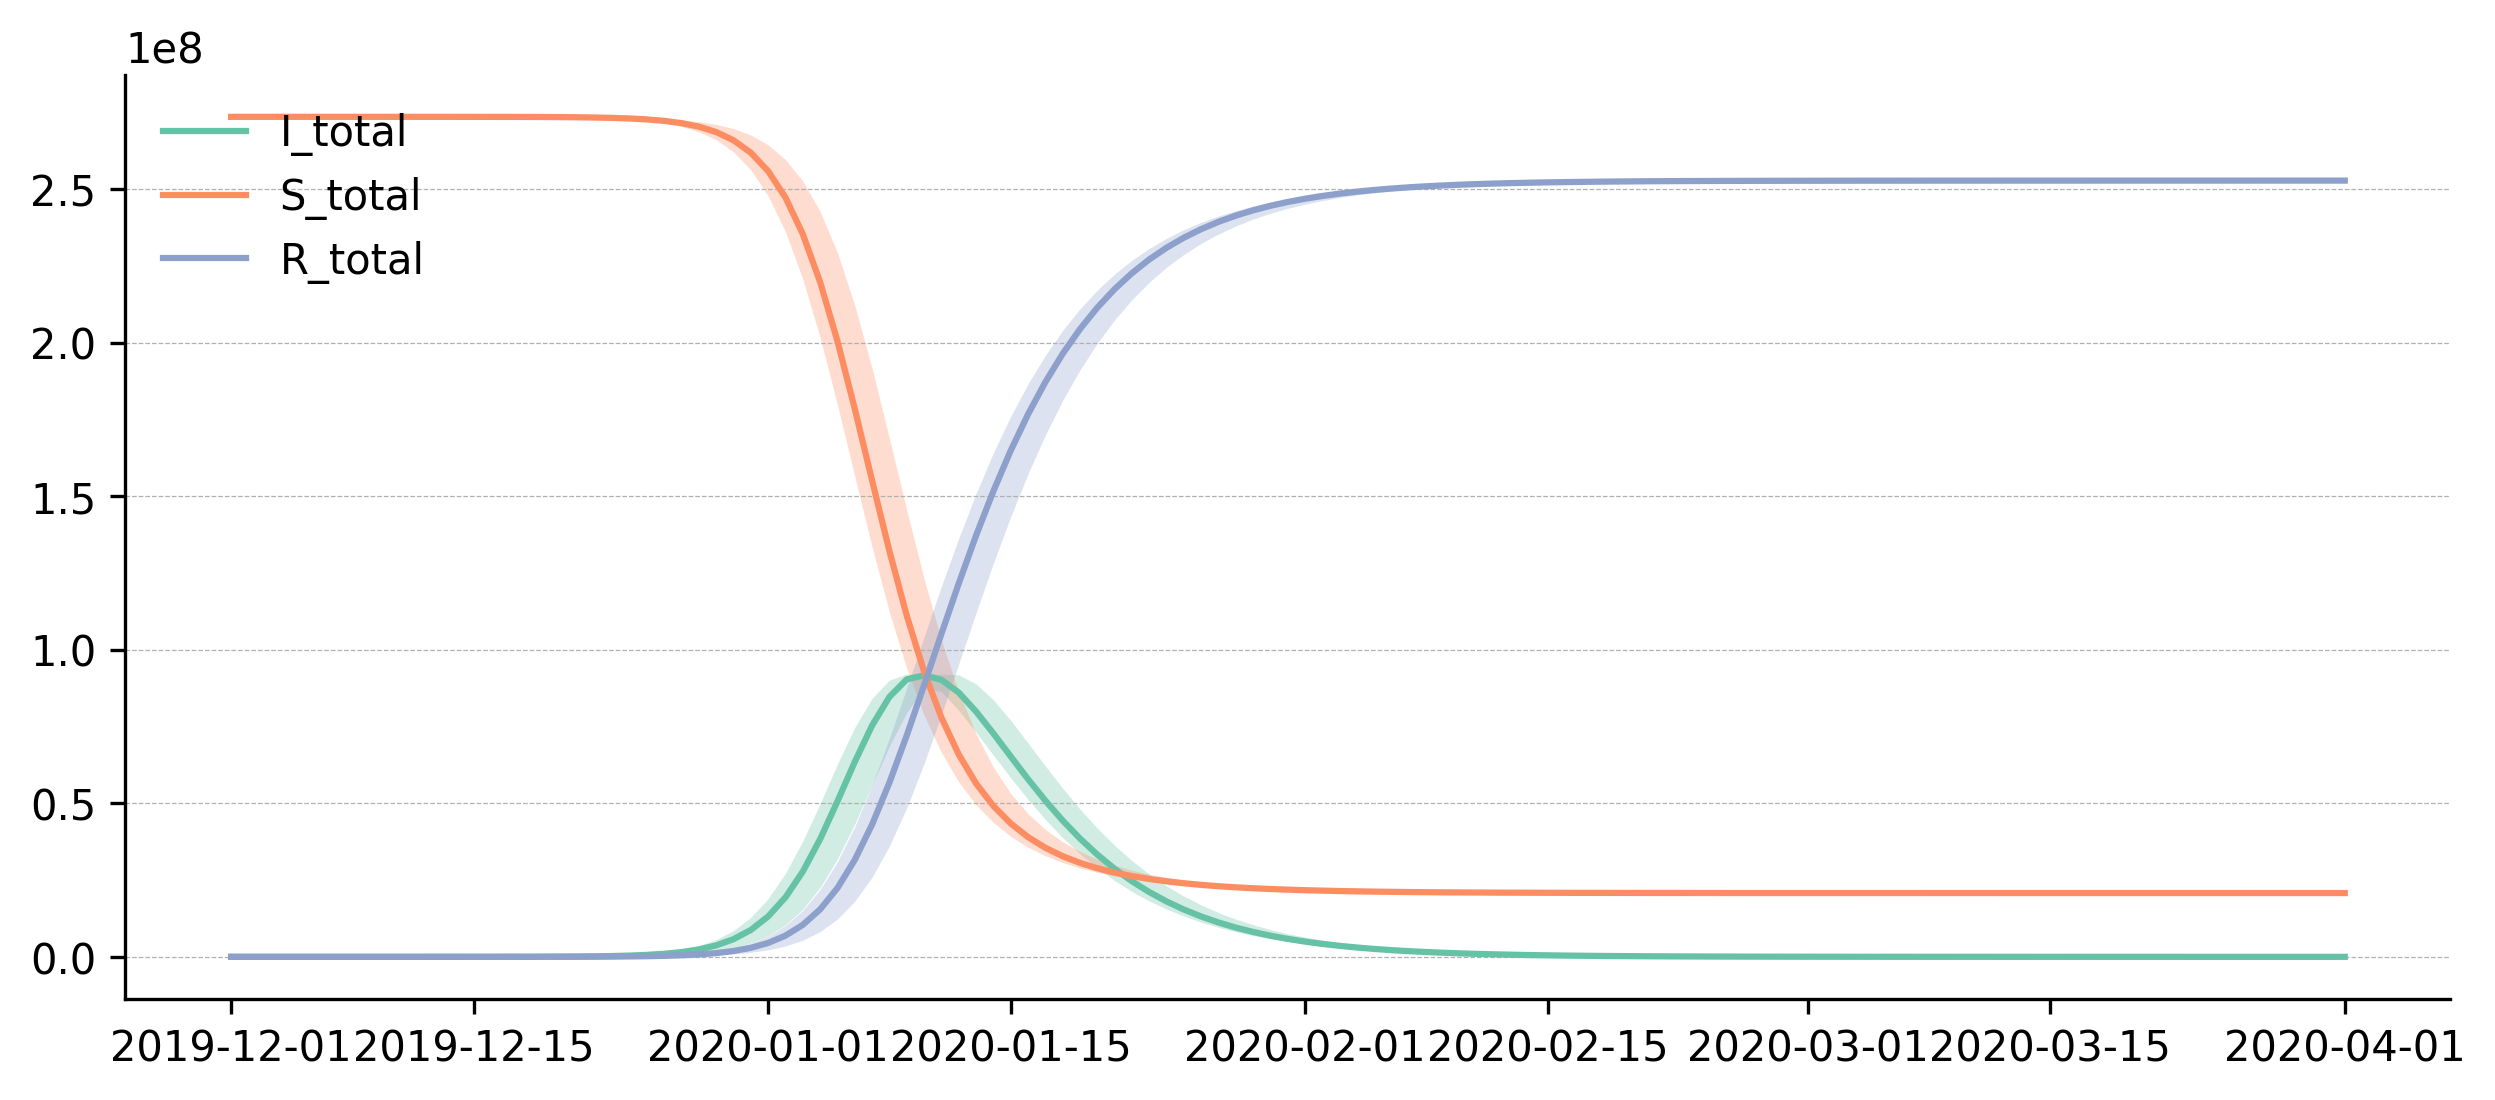

In [3]:
results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

Using ```add_parameter``` for multiple parameters:

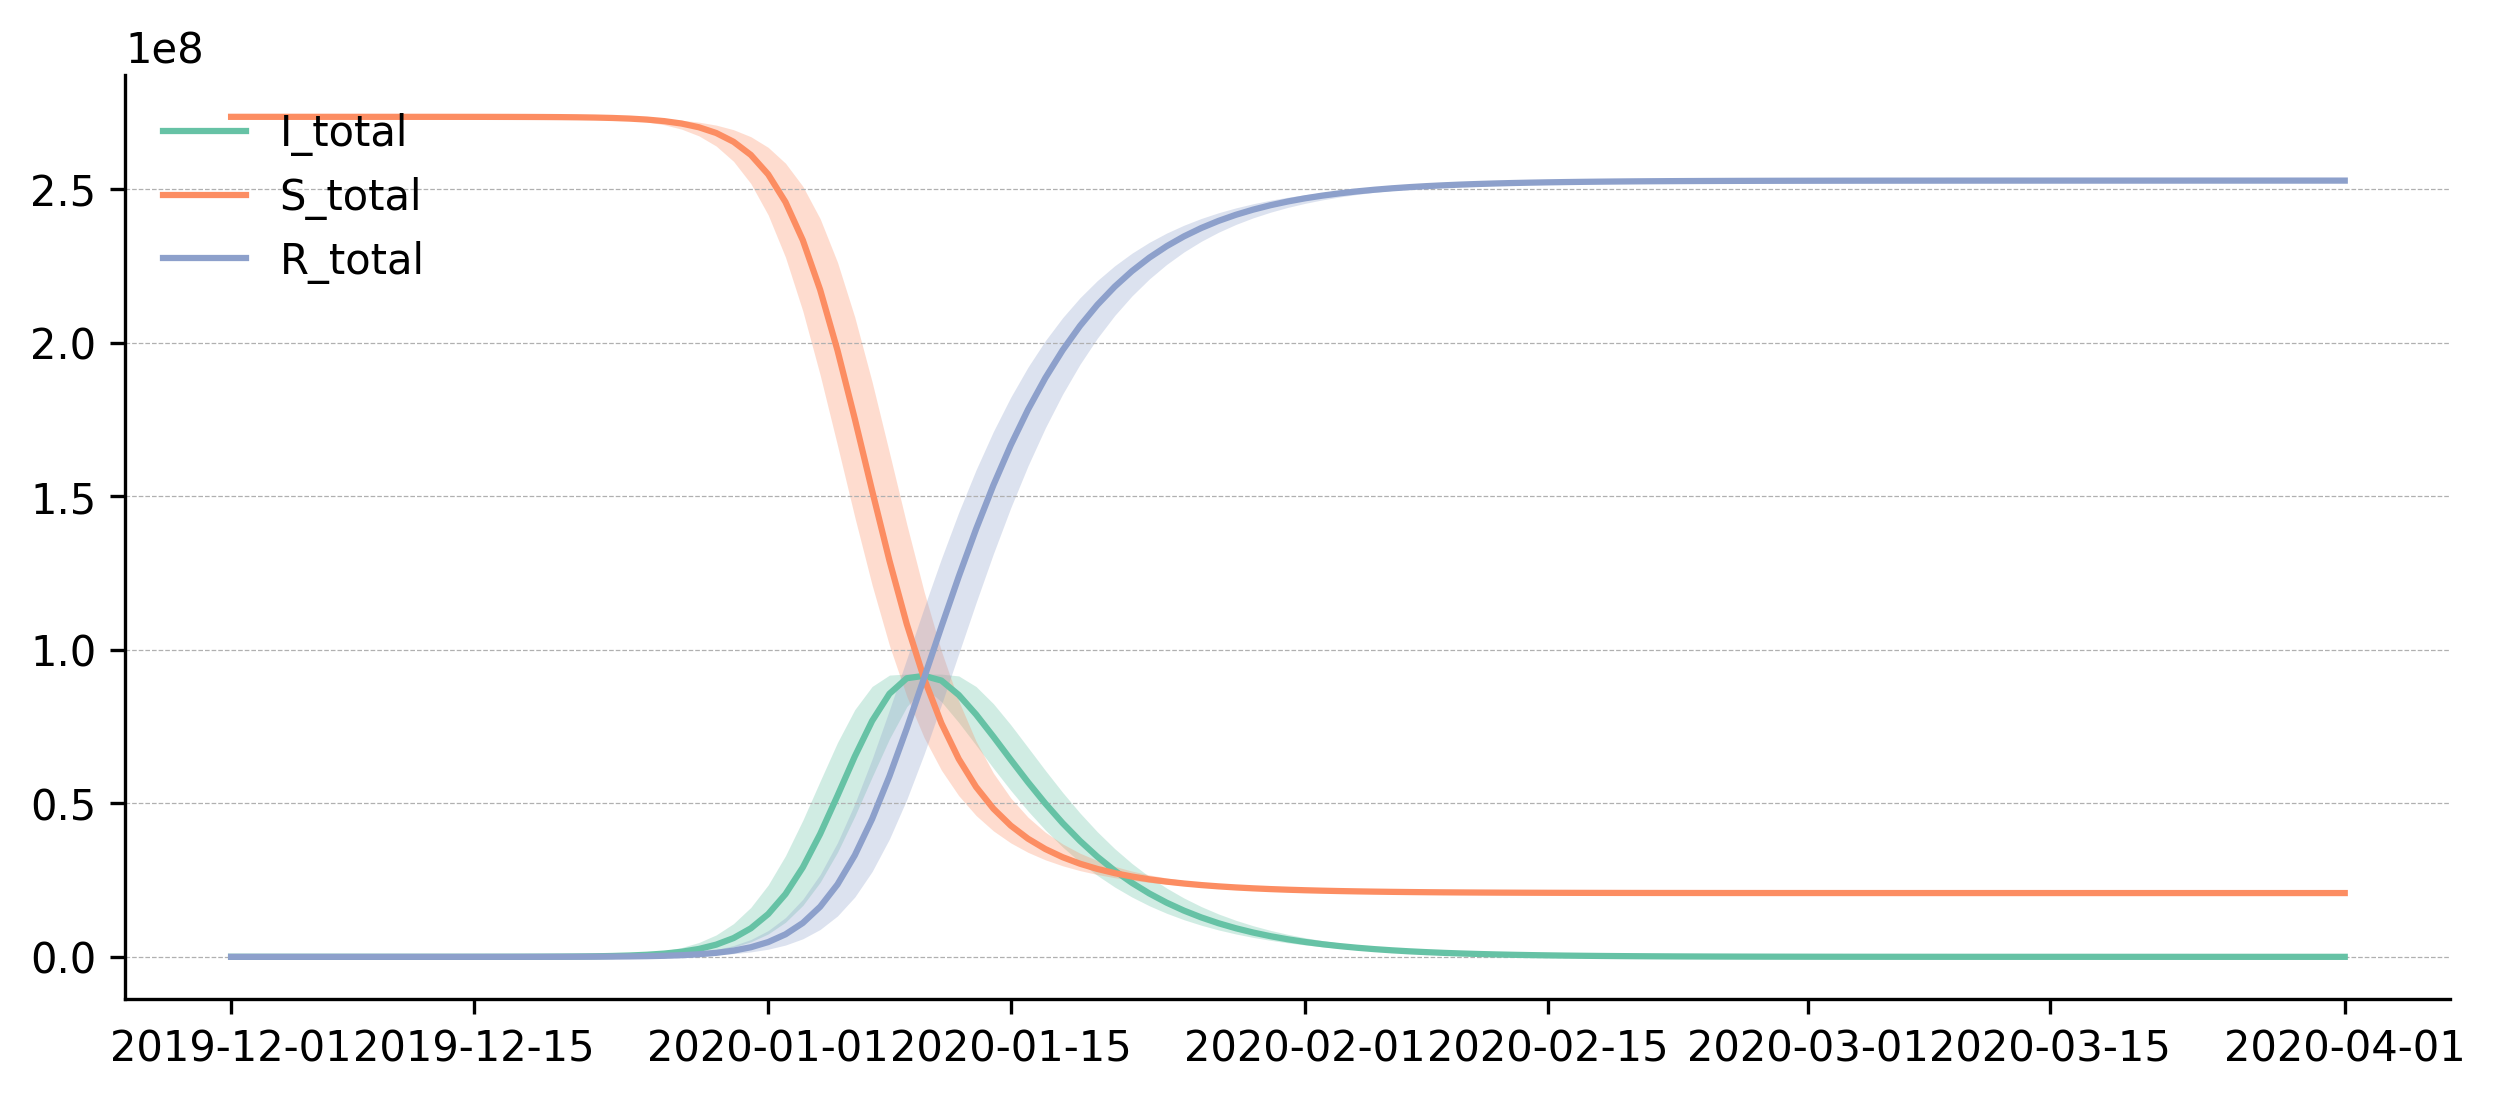

In [4]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])

# add parameters 
model.add_parameter(parameters_dict={"beta": 0.04, "mu": 0.2})

# add transitions 
model.add_transition(source="S", target="I", rate="beta", agent="I")
model.add_transition(source="I", target="R", rate="mu")


results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

Passing directly scalars to ```add_transition```:

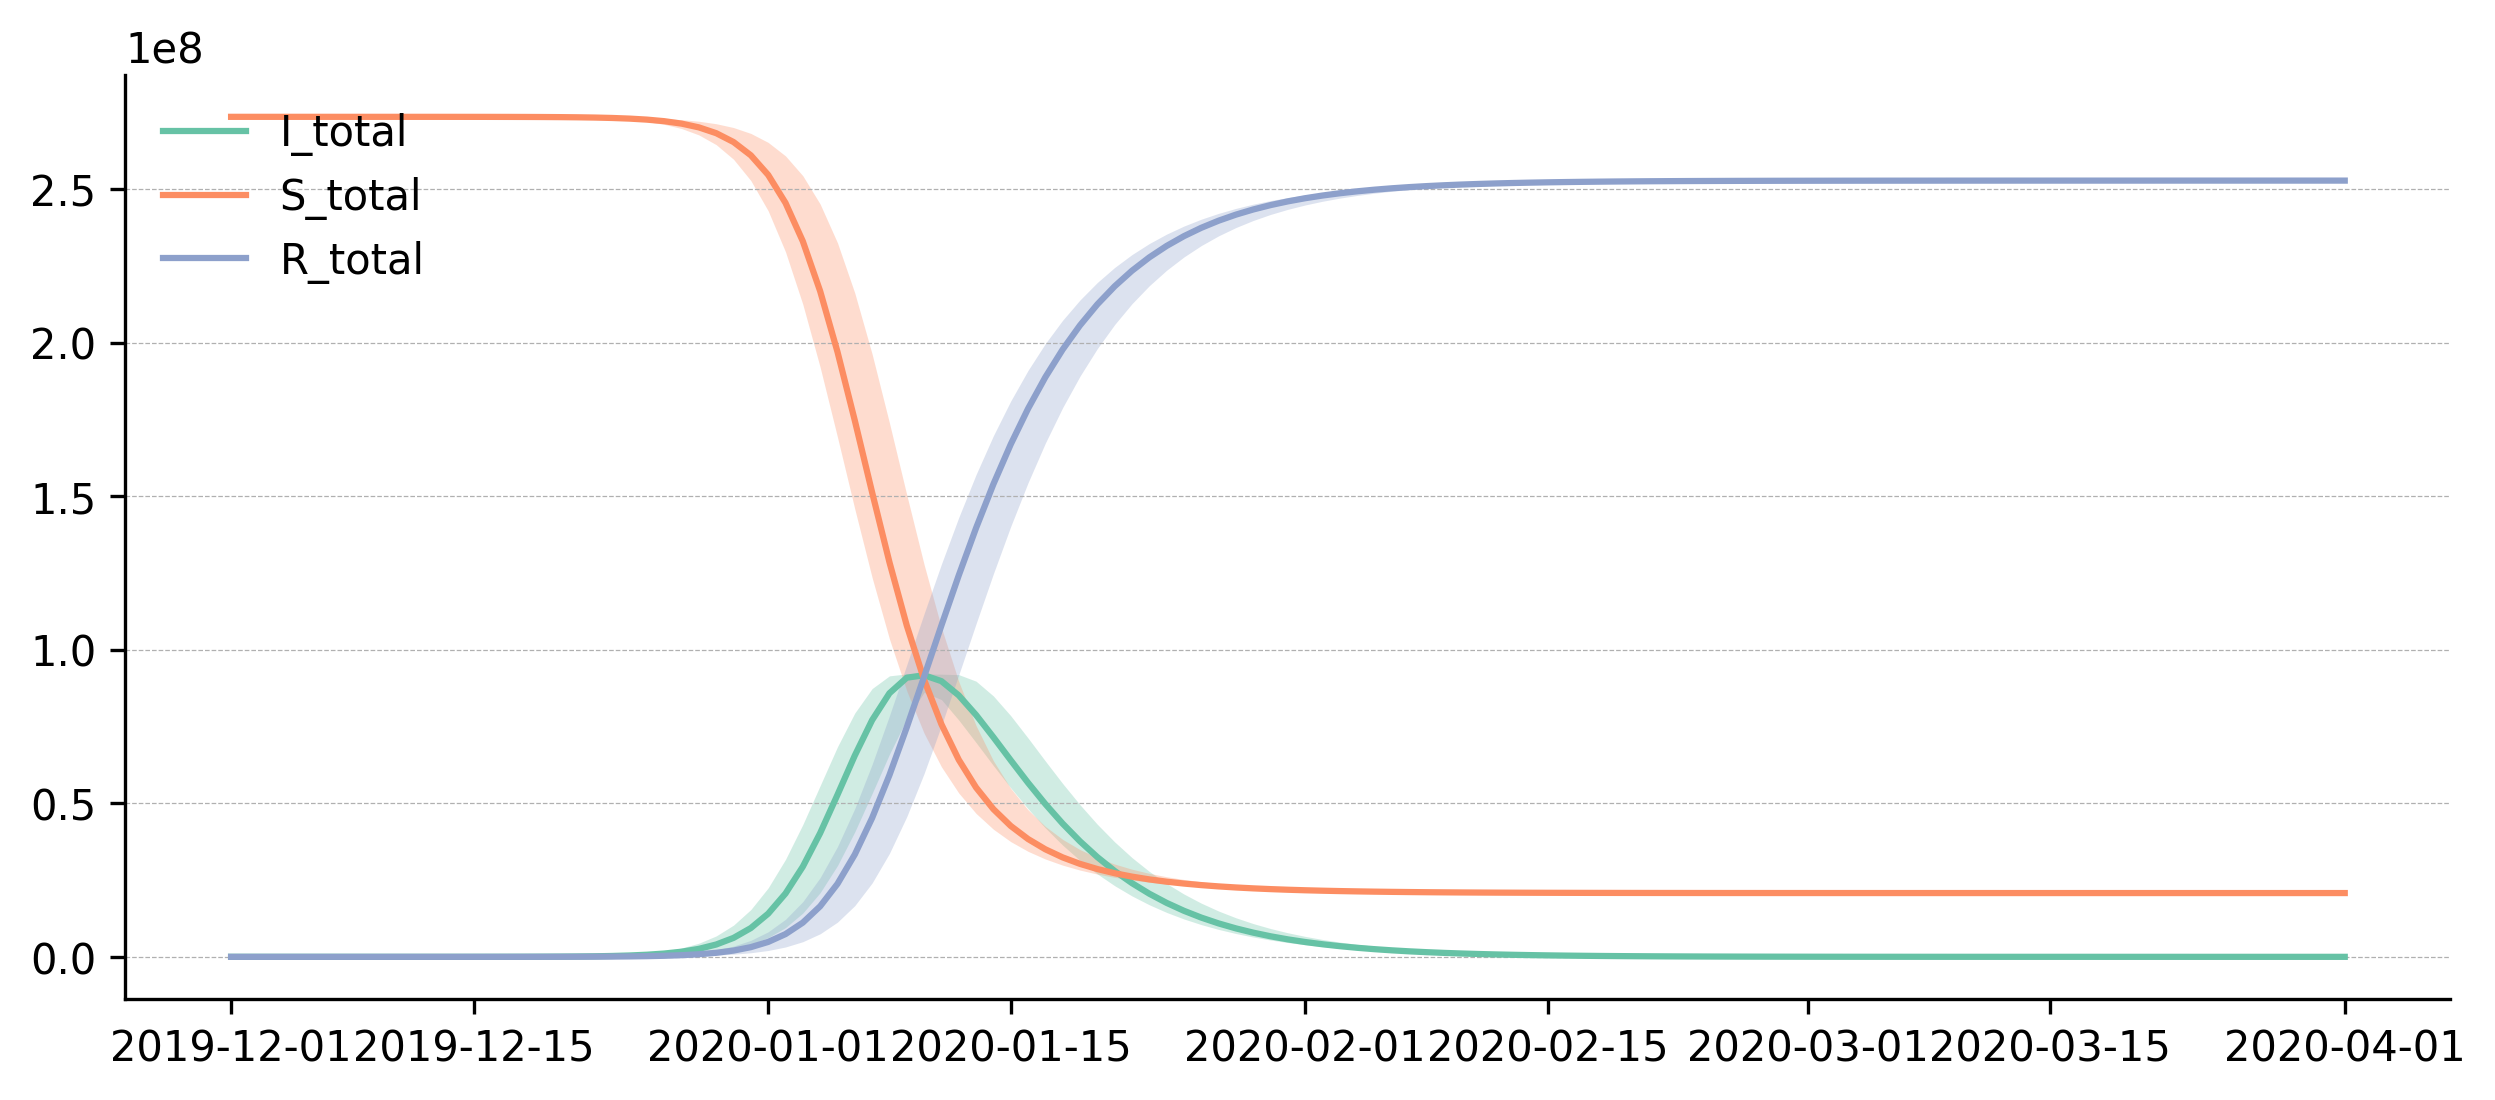

In [5]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])

# add transitions 
model.add_transition(source="S", target="I", rate=0.04, agent="I")
model.add_transition(source="I", target="R", rate=0.2)


results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

Passing arrays to ```add_parameter```:

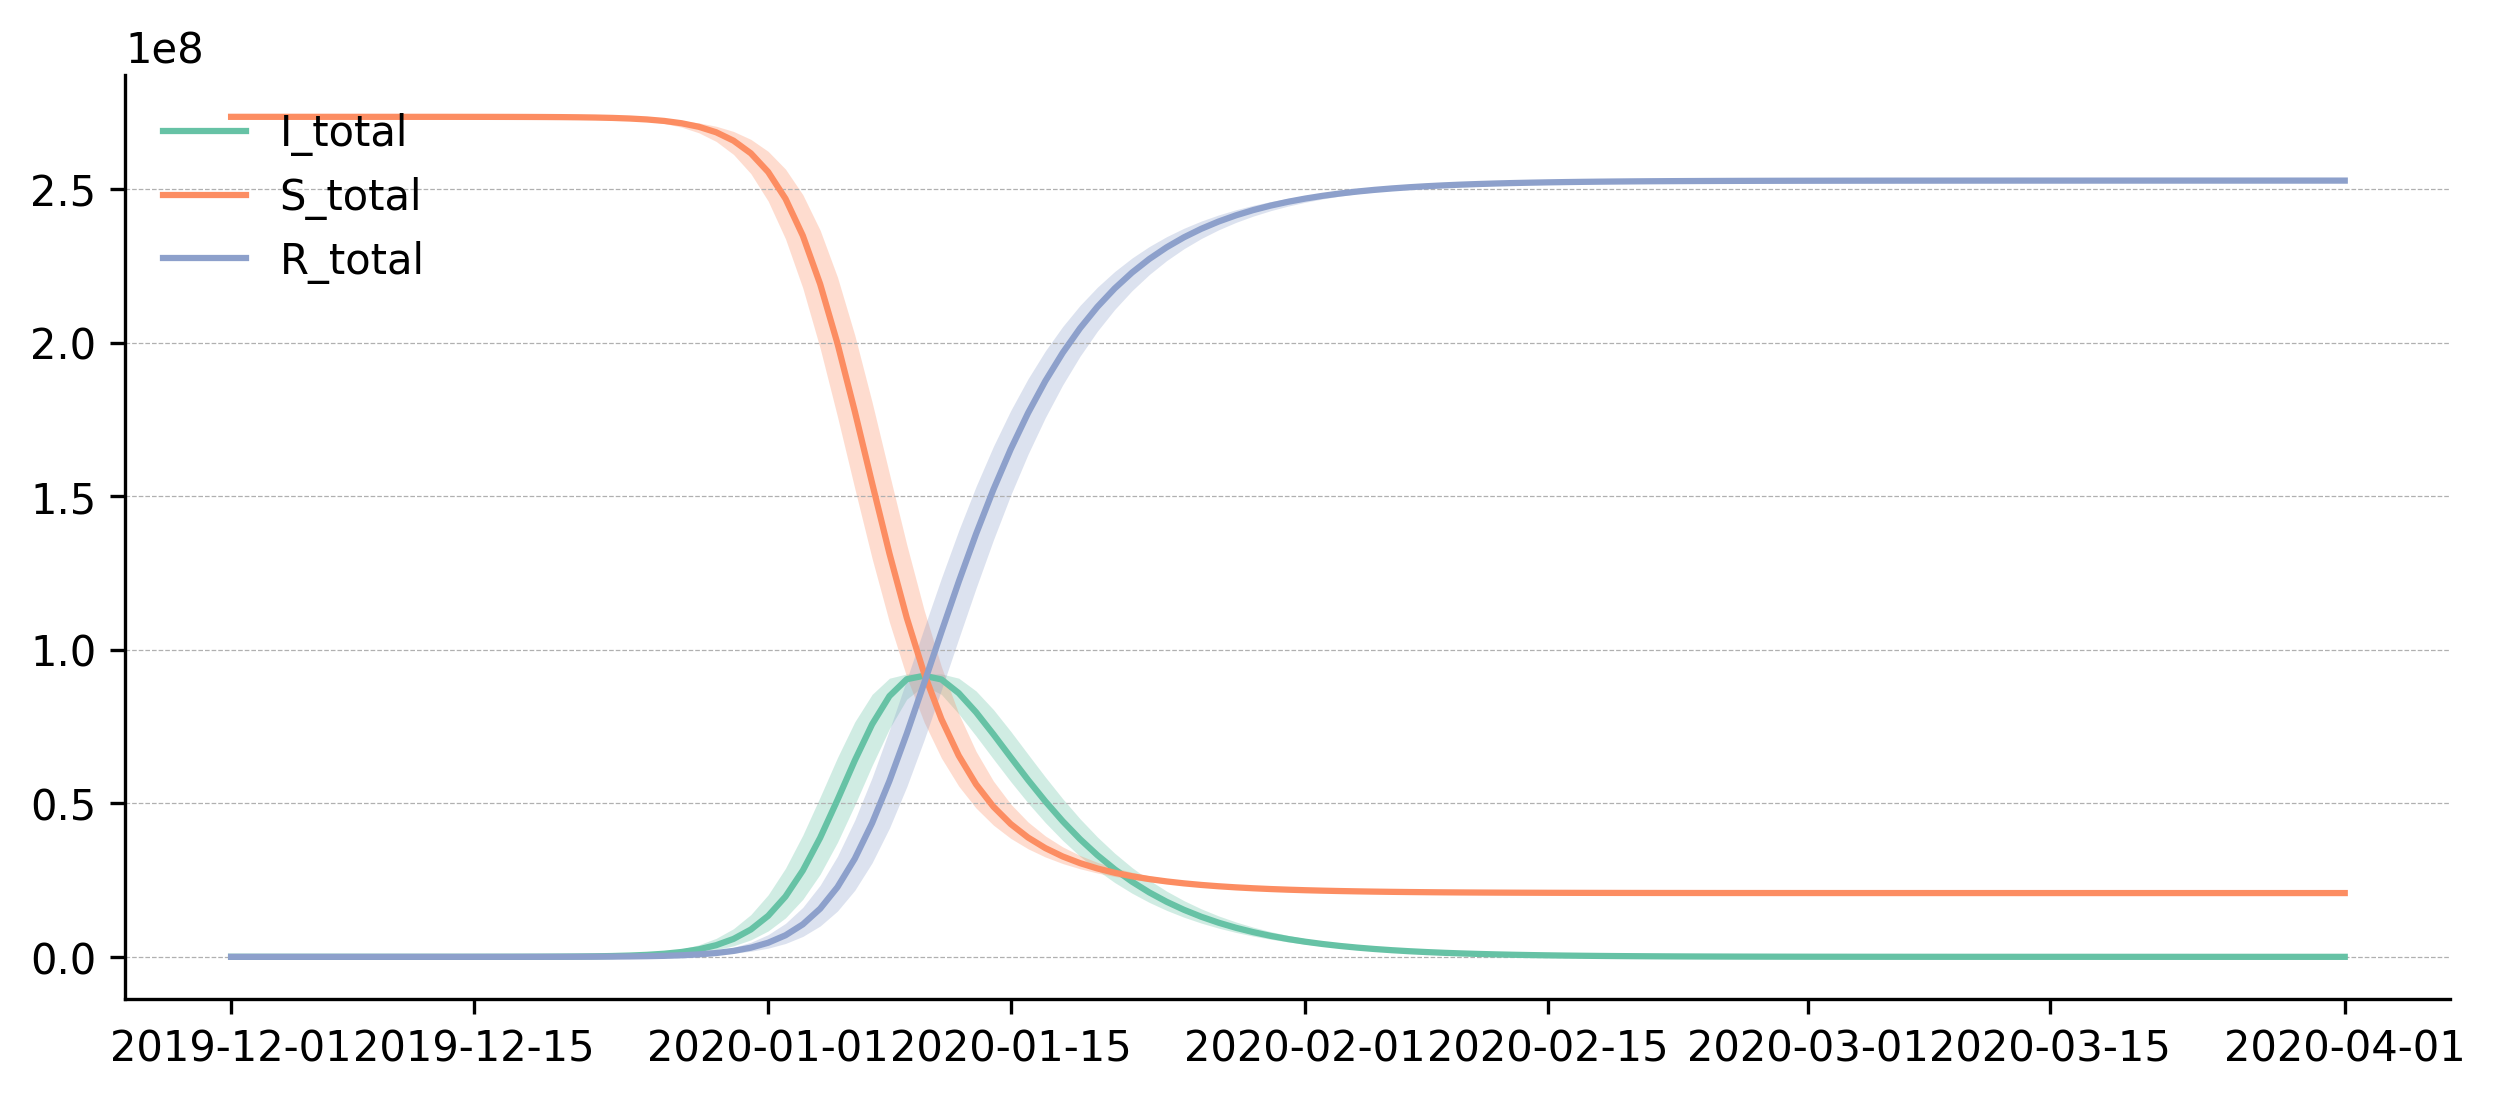

In [6]:
T = compute_days(start_date="2019-12-01", end_date="2020-04-01")

# create model 
model = EpiModel(compartments=["S", "I", "R"])

# add parameters 
model.add_parameter(name="mu", value=[0.2] * T)
model.add_parameter(parameters_dict={"beta":[0.04] * T})

# add transitions 
model.add_transition(source="S", target="I", rate="beta", agent="I")
model.add_transition(source="I", target="R", rate="mu")


results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

Passing directly arrays to ```add_transition```:

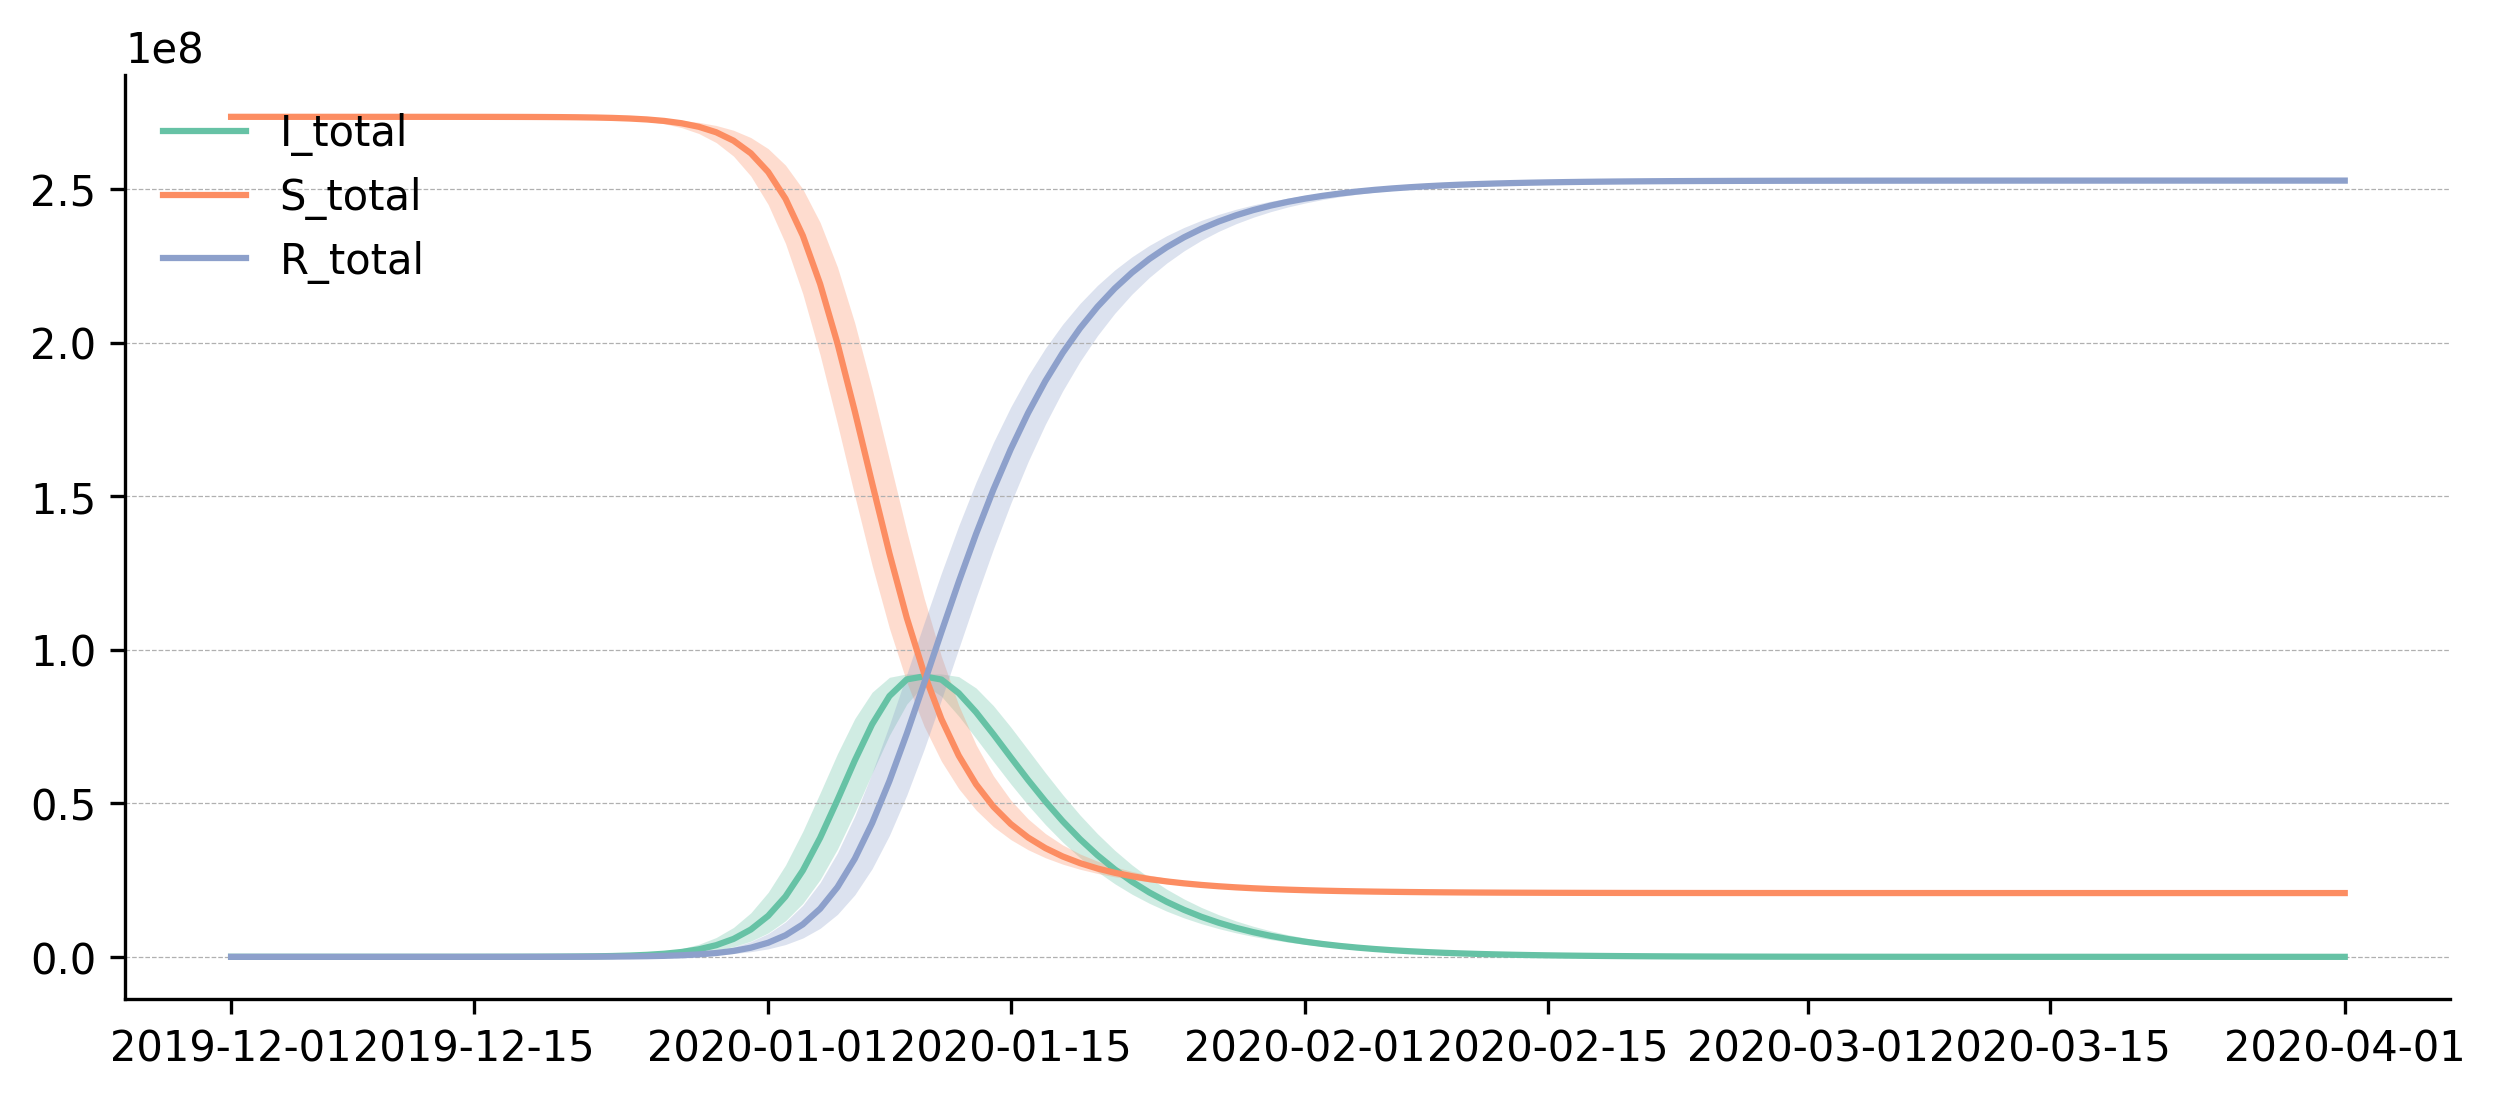

In [7]:
T = compute_days(start_date="2019-12-01", end_date="2020-04-01")

# create model 
model = EpiModel(compartments=["S", "I", "R"])

# add transitions 
model.add_transition(source="S", target="I", rate=[0.04] * T, agent="I")
model.add_transition(source="I", target="R", rate=[0.2] * T)


results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

# Parameter Overrides

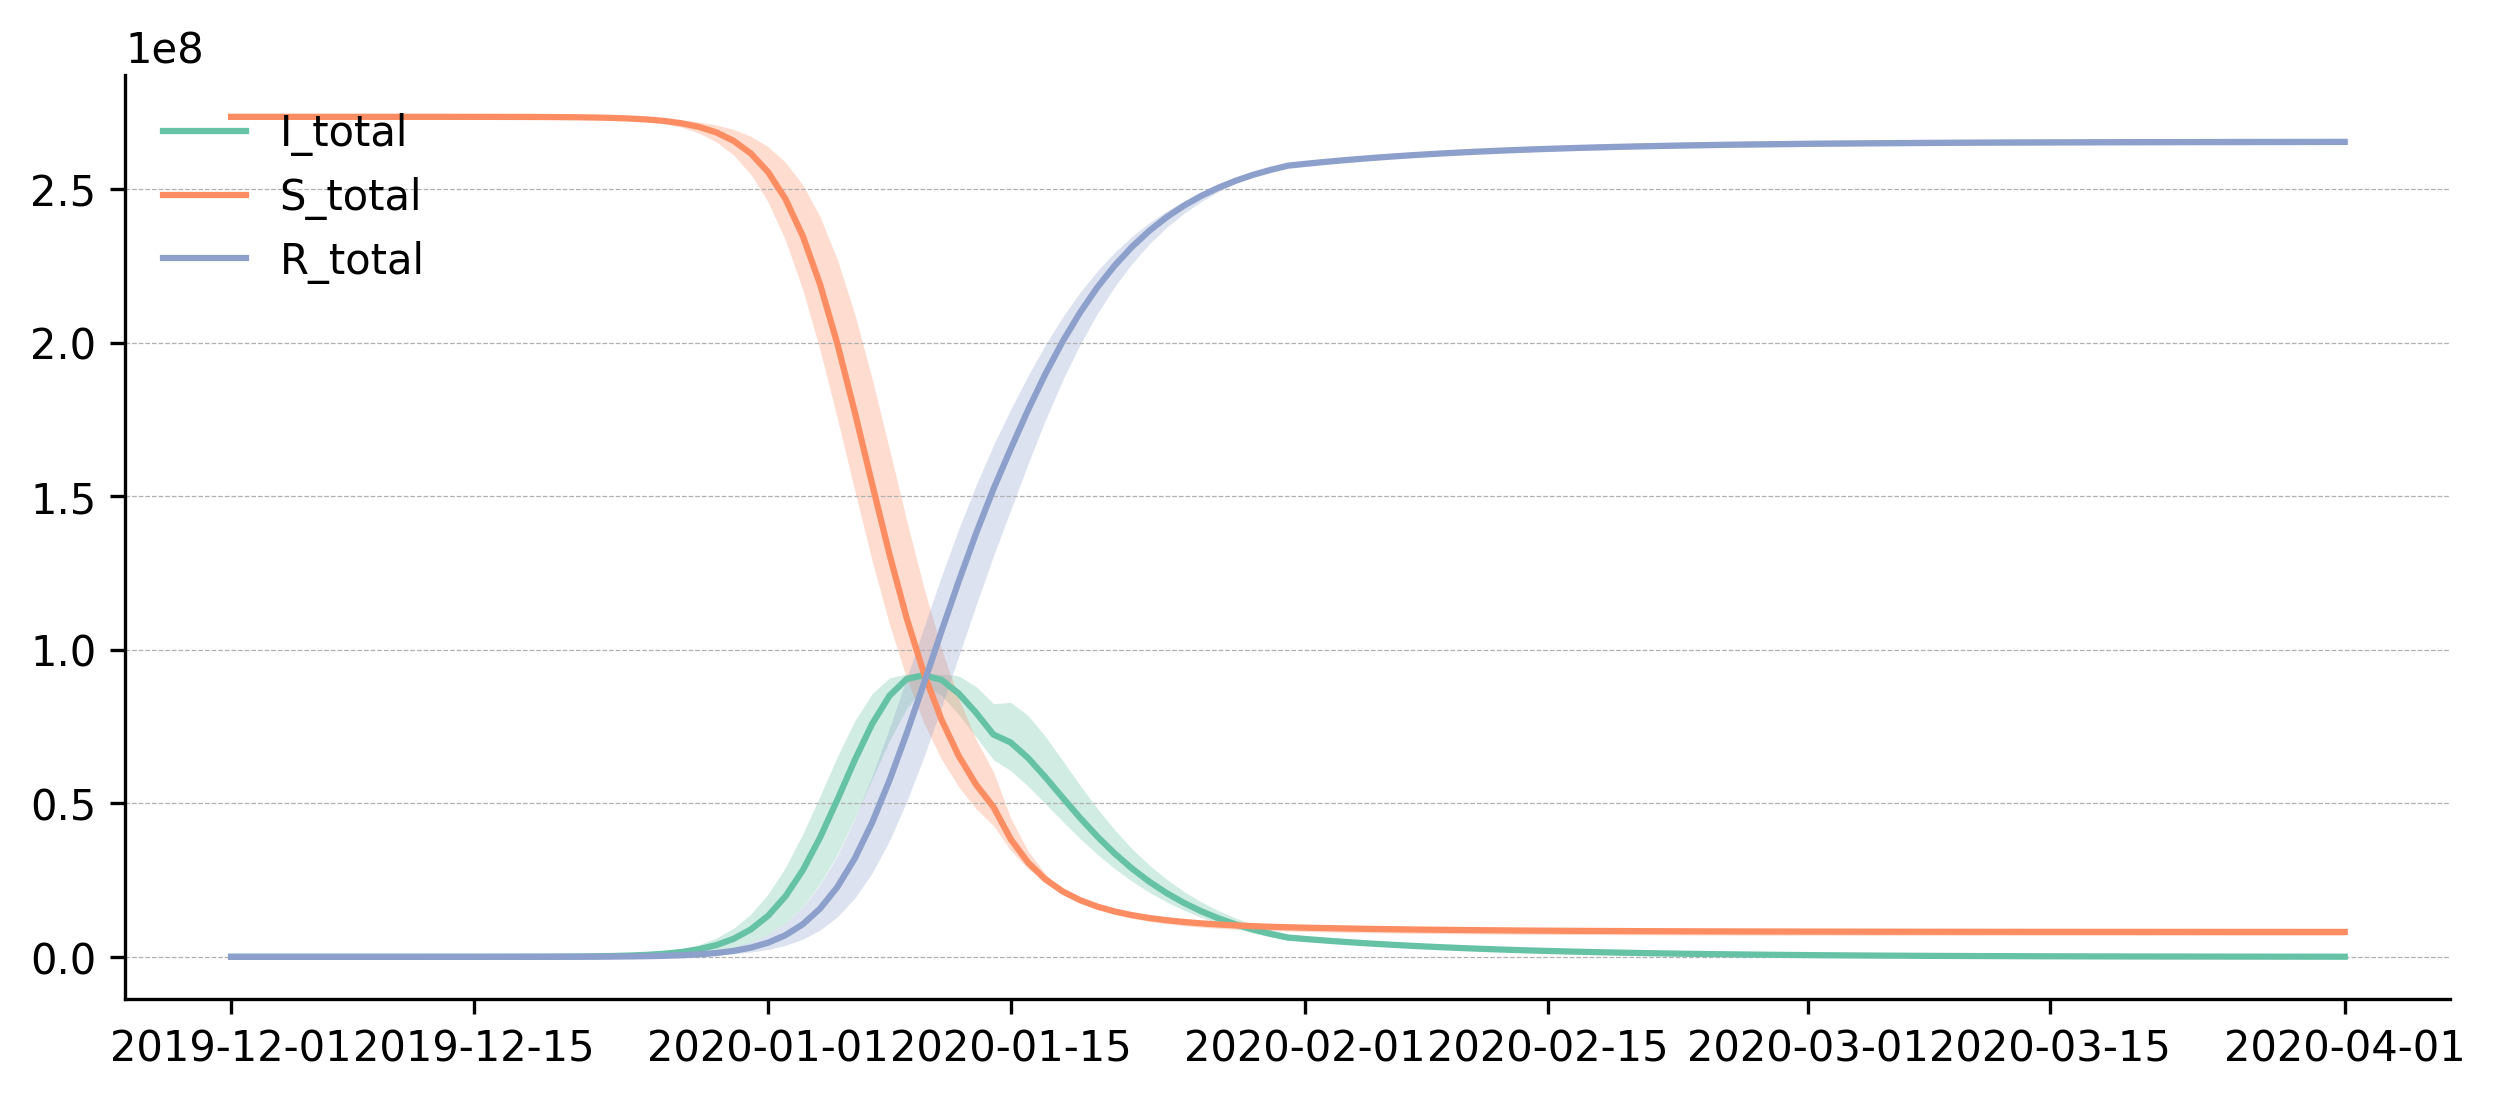

In [8]:
# create model 
model = EpiModel(compartments=["S", "R"])

# compartments can be also added after the first init call
model.add_compartments("I")

# define parameters
model.add_parameter(name="beta", value=0.04)
model.add_parameter(name="mu", value=0.2)

# add transitions 
model.add_transition(source="S", target="I", rate="beta", agent="I")
model.add_transition(source="I", target="R", rate="mu")

# overrides
model.override_parameter(start_date="2020-01-15", end_date="2020-04-01", name="beta", value=0.08)
model.override_parameter(start_date="2020-02-01", end_date="2020-04-01", name="mu", value=0.1)


results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])